In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install spacy
!pip install networkx
!pip install matplotlib.pyplot
!pip install re
!pip install os
!pip install pyvis
!pip install python_louvain

import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os
import re

from pyvis.network import Network
from community import community_louvain

!python -m spacy download en_core_web_sm
# installing and importing libraries needed

In [2]:
# function definitions

def load_books(book_folder):
    texts = []
    for file_name in os.listdir(book_folder):
        file_path = os.path.join(book_folder, file_name)
    
        # Check if the path is a file (not a directory)
        if os.path.isfile(file_path):
            texts.append(file_path)
    return texts

def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.character)
            or ent in list(character_df.character_firstname)
            or any(ent in alias_list for alias_list in character_df.aliases)]

def extract_last_name(full_name, last_names):
    for last_name in last_names:
        if last_name in full_name[0]:
            return last_name
    return full_name[0]

In [3]:
# load in text and langauge model

NER = spacy.load("en_core_web_sm")
texts = load_books("book_split_output")
# for text in texts:
#     book_doc = NER(open(text, 'r', encoding='utf-8').read())
book_doc = NER(open(texts[0], 'r', encoding='utf-8').read())

In [4]:
# load in names of characters
character_df = pd.read_csv("names.csv")


# add columns for different variations of name
character_df["character"] = character_df["character"].apply(lambda x: re.sub(r"[^\w\s]+", "", x))
character_df["character_firstname"] = character_df["character"].apply(lambda x: x.split(" ", 1) [0])
character_df["character_lastname"] = character_df["character"].apply(lambda x: x.split(" ", 1) [-1])
character_df["aliases"] = character_df["aliases"].apply(lambda x: [] if isinstance(x, float) else x.split(","))

# use NER to process and grab the list of entities and their sentences
sent_entity_df = []

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})

# turn list into df
sent_entity_df = pd.DataFrame(sent_entity_df)

# filter out only the character names
sent_entity_df["character_entities"] = sent_entity_df["entities"].apply(lambda x: filter_entity(x, character_df))

# filter out sentences that don't have any entities in them
sent_entity_df_filtered = sent_entity_df[sent_entity_df["character_entities"].map(len) > 0]

# set entity name to last name of entity to aggregate same names i.e. Kim Dokja vs Dokja should be counted as same
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered.apply(lambda row: [extract_last_name(row['character_entities'], character_df['character_lastname'])], axis=1)
pd.reset_option('^display.', silent = True)

C:\Users\tommy\AppData\Local\Temp\ipykernel_28040\2167441617.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered.apply(lambda row: [extract_last_name(row['character_entities'], character_df['character_lastname'])], axis=1)


In [5]:
# scroll through 5 lines at a time to aggregate relationships between characters and reorder to make sure A -> B is the same as B -> A
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i : end_i].character_entities), [])

    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i == 0) or char_list[i] != char_list[i-1]]
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})


In [6]:
# count the occurences of relationships between characters
relationship_df = pd.DataFrame(relationships)
relationship_df.head(10)
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index = False). sum()

In [7]:
relationship_df.head(10)

,source,target,value
0,Dokja,Sangah,4
1,Kang,Sangah,5
2,Hyunsung,Sangah,99
3,Hyunsung,Namwoon,17
4,Han,Namwoon,24
5,Namwoon,Sangah,3
6,Namwoon,One,5
7,Dokja,Hyunsung,6
8,Gilyoung,Sangah,80
9,Han,Hyunsung,47


In [8]:
G = nx.from_pandas_edgelist(relationship_df,
                           source = "source",
                           target = "target",
                           edge_attr = "value",
                           create_using = nx.Graph())
#this sets up our network for later graphs

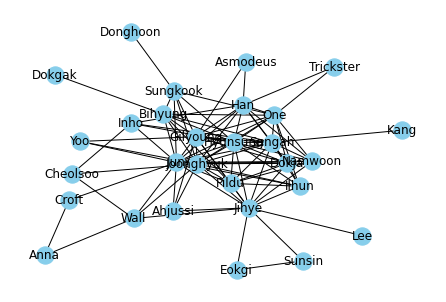

In [9]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

#this is the bad graph that's too clustered to see anything

In [11]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222',font_color='white')
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, "size")
net.from_nx(G)
net.show("orv.html")

orv.html


In [12]:
dict(G.degree)
#just to see how many connections there are

{'Dokja': 10,
 'Sangah': 14,
 'Kang': 1,
 'Hyunsung': 14,
 'Namwoon': 8,
 'Han': 11,
 'One': 12,
 'Gilyoung': 14,
 'Trickster': 2,
 'Joonghyuk': 17,
 'Wall': 5,
 'Bihyung': 9,
 'Dokgak': 1,
 'Cheolsoo': 3,
 'Inho': 5,
 'Jun': 18,
 'Yoo': 3,
 'Asmodeus': 2,
 'Jihye': 14,
 'Pildu': 10,
 'Ahjussi': 4,
 'Anna': 2,
 'Croft': 2,
 'Eokgi': 2,
 'Sunsin': 2,
 'Lee': 1,
 'Ilhun': 8,
 'Sungkook': 7,
 'Donghoon': 1}

In [13]:
#degree centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(centrality_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")
#centrality graph of first 10

NameError: name 'centrality_dict' is not defined

In [ ]:
#betweeness centrality 
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [ ]:
#closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [ ]:
#saving all centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [ ]:
#sorting people into which attributes best
communities = community_louvain.best_partition(G)
communities

In [ ]:
#sets the communities for the graph
nx.set_node_attributes(G, communities, "group")

In [ ]:
#color time
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222',font_color='white')
com_net.from_nx(G)
com_net.show("orv_communities.html")